In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
np.random.seed(12)
y = np.random.randint(0,4,300)
idx= []
for i in range(4):
    print(i,sum(y==i))
    idx.append(y==i)

0 80
1 72
2 75
3 73


In [3]:
x = np.zeros((300,2))

In [4]:
np.random.seed(12)
# covariance_matrix = np.eye(2)*0.01
# x[idx[0],:] = np.random.multivariate_normal(mean = [10,1],cov=covariance_matrix,size=sum(idx[0]))
# x[idx[1],:] = np.random.multivariate_normal(mean = [10,-1],cov=covariance_matrix,size=sum(idx[1]))
# x[idx[2],:] = np.random.multivariate_normal(mean = [15,0],cov=covariance_matrix,size=sum(idx[2]))
# x[idx[3],:] = np.random.multivariate_normal(mean = [-10,1],cov=np.eye(2)*0.5,size=sum(idx[3]))

x[idx[0],:] = np.random.uniform(low=[5,2],high=[6,4],size=(sum(idx[0]),2))

x[idx[1],:] = np.random.uniform(low=[5,-3],high=[6,-5],size=(sum(idx[1]),2))

x[idx[2],:] = np.random.uniform(low=[8,0],high=[9,-2],size=(sum(idx[2]),2))

x[idx[3],:] = np.random.uniform(low=[1,-1],high=[2,5],size=(sum(idx[3]),2))


In [5]:
x = (x-np.mean(x,axis=0,keepdims=True))/np.std(x,axis=0,keepdims=True)

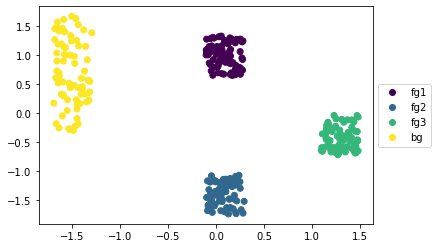

In [6]:
scatter = plt.scatter(x[:,0],x[:,1],c=y)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))

In [7]:
desired_num = 1100
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 100
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1100/1100 [00:02<00:00, 534.85it/s]


In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [9]:
batch = 250
training_size = 100
msd1 = MosaicDataset(mosaic_list_of_images[0:training_size], mosaic_label[0:training_size] , fore_idx[0:training_size])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

msd2 = MosaicDataset(mosaic_list_of_images[training_size:], mosaic_label[training_size:] , fore_idx[training_size:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [10]:
def my_cross_entropy(output,target,alpha,n_classes):
    if n_classes>2:
        criterion = nn.CrossEntropyLoss(reduce=False)
    else:
        criterion = nn.BCELoss(reduce=False)
    
    batch = output.size(0)
    patches = output.size(1)
    
    
    output = torch.reshape(output,(batch*patches,3))
    
    
    target = target.repeat_interleave(patches)
    
    loss = criterion(output,target)
    
    loss = torch.reshape(loss,(batch,patches))

    final_loss = torch.sum(torch.mul(loss,alpha),dim=1)

    final_loss = torch.mean(final_loss,dim=0)
    return final_loss

In [11]:
def save_analysis(trainloader,testloader,focus,classification,n_classes):
    focus.eval()
    classification.eval()
    fg_indexes = []
    alpha_argmax = []
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in trainloader:
            inputs, labels,foregrnd_index = data
            inputs = inputs.double()
            inputs = inputs.to(device)
            alphas,attnd_inputs= focus(inputs)
            outputs = classification(attnd_inputs)
            if n_classes > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
            
            true_labels.append(labels)
            predicted_labels.append(predicted.cpu().numpy())
            index = torch.argmax(alphas,dim=1)
            fg_indexes.append(foregrnd_index.numpy())
            alpha_argmax.append(index.cpu().numpy())
            #print(alphas[labels==0].shape,torch.max(alphas[labels==0],dim=1),"foreground",foregrnd_index[labels==0])
            #print(alphas[labels==1].shape,torch.max(alphas[labels==1],dim=1),"foreground",foregrnd_index[labels==1])
            #print(alphas[labels==2].shape,torch.max(alphas[labels==2],dim=1),"foreground",foregrnd_index[labels==2])
    fg_indexes = np.concatenate(fg_indexes,axis=0)
    alpha_argmax = np.concatenate(alpha_argmax,axis=0)
    true_labels = np.concatenate(true_labels,axis=0)
    predicted_labels = np.concatenate(predicted_labels,axis=0)

    
    ftpt = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels == true_labels))
    ffpt = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels == true_labels))
    ftpf = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels != true_labels))
    ffpf = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels != true_labels))
    trn_analysis = [ftpt,ffpt,ftpf,ffpf]
    
    fg_indexes = []
    alpha_argmax = []
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels,foregrnd_index = data
            inputs = inputs.double()
            inputs = inputs.to(device)
            alphas,attnd_inputs= focus(inputs)
            outputs = classification(attnd_inputs)
            if len(torch.unique(labels)) > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
                
            true_labels.append(labels)
            predicted_labels.append(predicted.cpu().numpy())
            index = torch.argmax(alphas,dim=1)
            fg_indexes.append(foregrnd_index.numpy())
            alpha_argmax.append(index.cpu().numpy())
    fg_indexes = np.concatenate(fg_indexes,axis=0)
    alpha_argmax = np.concatenate(alpha_argmax,axis=0)
    true_labels = np.concatenate(true_labels,axis=0)
    predicted_labels = np.concatenate(predicted_labels,axis=0)    
    ftpt = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels == true_labels))
    ffpt = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels == true_labels))
    ftpf = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels != true_labels))
    ffpf = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels != true_labels))
    tst_analysis = [ftpt,ffpt,ftpf,ffpf]
    
    
    return trn_analysis,tst_analysis

# soft attention

In [12]:
class Focus(nn.Module):
    def __init__(self,input_dims,attention,bias_=False,bn_=False):
        super(Focus, self).__init__()
        self.input_dims = input_dims 
        self.attention = attention
        self.bias_ = bias_
        self.fc1 = nn.Linear(self.input_dims,1, bias=self.bias_)
        self.bn_ = bn_
        if self.bn_:
            self.bn = nn.BatchNorm1d(input_dims)
        
    def forward_soft_Attention(self,z):
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,self.input_dims)
        alp1,ft1 = self.helper(z)
        alpha = F.softmax(alp1,dim=1)
        y = torch.sum(alpha*ft1,dim=1)
        
        if self.bn_:
            y = self.bn(y)
        
        alpha =alpha[:,:,0]
        return alpha,y   # return  alpha values,attended data
    def forward_hard_Attention(self,z):
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)

        alpha = F.softmax(alp1,dim=1)
        
        if self.training:
            alpha =alpha[:,:,0]
            y = ft1 
            return alpha,y
        else:
            index = torch.argmax(alpha,dim=1)
            #print(index)
            hard_alpha = torch.nn.functional.one_hot(index[:,0], patches)
            y = torch.sum(hard_alpha[:,:,None]*ft1,dim=1)
            alpha = alpha[:,:,0]
            return alpha,y
        
    def forward(self,z): 
        if self.attention == "hard":
            alpha,y = self.forward_hard_Attention(z)
            return alpha,y
        elif self.attention == "soft":
            alpha,y = self.forward_soft_Attention(z)
            return alpha,y
        else:
            print("not correct Attention type")
            return None

    def helper(self, x):
        x1 = x
        x = self.fc1(x)
        return x,x1

In [13]:
class Classification(nn.Module):
    def __init__(self,input_dims,output_dims):
        super(Classification, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims 
        self.fc1 = nn.Linear(self.input_dims, self.output_dims)
    def forward(self, x):
        x = self.fc1(x)
        if self.output_dims ==1:
            x = torch.sigmoid(x)
        return x

In [14]:
def initialize_zeros_weights(m):
    if isinstance(m,nn.Linear):
        nn.init.zeros_(m.weight.data)
        if m.bias is not None:
            nn.init.zeros_(m.bias.data)

In [15]:
def train_attention_models(trainloader,focus_module,classification_module,
                           n_classes,nos_epochs,attention,learning_rate=0.01):
    
    
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCELoss()
    optimizer_classify = optim.SGD(classification_module.parameters(), lr=learning_rate)#,  momentum=0.09)
    optimizer_focus = optim.SGD(focus_module.parameters(), lr=learning_rate)# , momentum=0.09)
    loss_list=[]
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        focus_module.train()
        classification_module.train()
        for i, data in  enumerate(trainloader):
            inputs , labels , fore_idx = data
            batch = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.double()
            # zero the parameter gradients
            optimizer_focus.zero_grad()
            optimizer_classify.zero_grad()
            alphas, avg_images = focus_module(inputs)
            outputs = classification_module(avg_images)
            #print(outputs.shape)
            
            # predicted values
            if n_classes > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
            
            # calculate loss
            if attention == "soft":
                loss = criterion(outputs,labels)
            if attention == "hard":
                loss = my_cross_entropy(outputs,labels,alphas,n_classes)
            loss.backward()
            optimizer_focus.step()
            optimizer_classify.step()
            epoch_loss.append(loss.item())
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        if(np.mean(epoch_loss) <= 0.01):
            break
    print('Finished Training')
    return focus_module,classification_module,loss_list 


In [16]:
focus_net = Focus(input_dims = 2,attention="soft",bias_=False,bn_=False).double()
focus_net = focus_net.to(device)

classify = Classification(input_dims=2,output_dims=3).double()
classify = classify.to(device)

focus_net.apply(initialize_zeros_weights)
classify.apply(initialize_zeros_weights)
# parameters
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)


In [17]:
save_analysis(train_loader,test_loader,focus_net,classify,3) # ftpt ffpt ftpf ffpf

([0, 26, 0, 74], [4, 319, 9, 668])

In [18]:
focus_net,classify,loss_list = train_attention_models(train_loader,focus_net,classify,
                           learning_rate=0.5,n_classes=3,nos_epochs=10000,attention="soft")

[1] loss: 1.099
[2] loss: 1.087
[3] loss: 1.086
[4] loss: 1.085
[5] loss: 1.085
[6] loss: 1.085
[7] loss: 1.085
[8] loss: 1.085
[9] loss: 1.085
[10] loss: 1.085
[11] loss: 1.085
[12] loss: 1.085
[13] loss: 1.085
[14] loss: 1.085
[15] loss: 1.085
[16] loss: 1.085
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085
[53] loss: 1.085
[54] loss: 1.085
[55] loss: 1.085
[56] loss: 1.085
[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] l

[559] loss: 1.078
[560] loss: 1.078
[561] loss: 1.078
[562] loss: 1.078
[563] loss: 1.078
[564] loss: 1.078
[565] loss: 1.078
[566] loss: 1.078
[567] loss: 1.078
[568] loss: 1.078
[569] loss: 1.078
[570] loss: 1.078
[571] loss: 1.078
[572] loss: 1.078
[573] loss: 1.078
[574] loss: 1.078
[575] loss: 1.078
[576] loss: 1.078
[577] loss: 1.078
[578] loss: 1.078
[579] loss: 1.078
[580] loss: 1.078
[581] loss: 1.078
[582] loss: 1.078
[583] loss: 1.078
[584] loss: 1.078
[585] loss: 1.078
[586] loss: 1.078
[587] loss: 1.078
[588] loss: 1.078
[589] loss: 1.078
[590] loss: 1.078
[591] loss: 1.078
[592] loss: 1.078
[593] loss: 1.078
[594] loss: 1.078
[595] loss: 1.078
[596] loss: 1.078
[597] loss: 1.078
[598] loss: 1.078
[599] loss: 1.078
[600] loss: 1.078
[601] loss: 1.078
[602] loss: 1.078
[603] loss: 1.078
[604] loss: 1.078
[605] loss: 1.078
[606] loss: 1.078
[607] loss: 1.078
[608] loss: 1.078
[609] loss: 1.078
[610] loss: 1.078
[611] loss: 1.078
[612] loss: 1.078
[613] loss: 1.078
[614] loss

[1019] loss: 1.073
[1020] loss: 1.073
[1021] loss: 1.073
[1022] loss: 1.073
[1023] loss: 1.073
[1024] loss: 1.073
[1025] loss: 1.073
[1026] loss: 1.073
[1027] loss: 1.073
[1028] loss: 1.073
[1029] loss: 1.073
[1030] loss: 1.073
[1031] loss: 1.073
[1032] loss: 1.073
[1033] loss: 1.073
[1034] loss: 1.073
[1035] loss: 1.073
[1036] loss: 1.073
[1037] loss: 1.073
[1038] loss: 1.073
[1039] loss: 1.073
[1040] loss: 1.073
[1041] loss: 1.073
[1042] loss: 1.073
[1043] loss: 1.073
[1044] loss: 1.073
[1045] loss: 1.073
[1046] loss: 1.073
[1047] loss: 1.073
[1048] loss: 1.073
[1049] loss: 1.073
[1050] loss: 1.073
[1051] loss: 1.073
[1052] loss: 1.073
[1053] loss: 1.073
[1054] loss: 1.073
[1055] loss: 1.073
[1056] loss: 1.073
[1057] loss: 1.072
[1058] loss: 1.072
[1059] loss: 1.072
[1060] loss: 1.072
[1061] loss: 1.072
[1062] loss: 1.072
[1063] loss: 1.072
[1064] loss: 1.072
[1065] loss: 1.072
[1066] loss: 1.072
[1067] loss: 1.072
[1068] loss: 1.072
[1069] loss: 1.072
[1070] loss: 1.072
[1071] loss:

[1472] loss: 1.069
[1473] loss: 1.069
[1474] loss: 1.069
[1475] loss: 1.069
[1476] loss: 1.069
[1477] loss: 1.069
[1478] loss: 1.069
[1479] loss: 1.069
[1480] loss: 1.069
[1481] loss: 1.069
[1482] loss: 1.069
[1483] loss: 1.069
[1484] loss: 1.069
[1485] loss: 1.069
[1486] loss: 1.069
[1487] loss: 1.069
[1488] loss: 1.069
[1489] loss: 1.069
[1490] loss: 1.069
[1491] loss: 1.069
[1492] loss: 1.069
[1493] loss: 1.069
[1494] loss: 1.069
[1495] loss: 1.069
[1496] loss: 1.069
[1497] loss: 1.069
[1498] loss: 1.069
[1499] loss: 1.069
[1500] loss: 1.069
[1501] loss: 1.069
[1502] loss: 1.069
[1503] loss: 1.069
[1504] loss: 1.069
[1505] loss: 1.069
[1506] loss: 1.069
[1507] loss: 1.069
[1508] loss: 1.069
[1509] loss: 1.069
[1510] loss: 1.069
[1511] loss: 1.069
[1512] loss: 1.069
[1513] loss: 1.069
[1514] loss: 1.069
[1515] loss: 1.069
[1516] loss: 1.069
[1517] loss: 1.069
[1518] loss: 1.069
[1519] loss: 1.069
[1520] loss: 1.069
[1521] loss: 1.069
[1522] loss: 1.069
[1523] loss: 1.069
[1524] loss:

[1945] loss: 1.066
[1946] loss: 1.066
[1947] loss: 1.066
[1948] loss: 1.066
[1949] loss: 1.066
[1950] loss: 1.066
[1951] loss: 1.066
[1952] loss: 1.066
[1953] loss: 1.066
[1954] loss: 1.066
[1955] loss: 1.066
[1956] loss: 1.066
[1957] loss: 1.066
[1958] loss: 1.066
[1959] loss: 1.066
[1960] loss: 1.066
[1961] loss: 1.066
[1962] loss: 1.066
[1963] loss: 1.066
[1964] loss: 1.066
[1965] loss: 1.066
[1966] loss: 1.066
[1967] loss: 1.066
[1968] loss: 1.066
[1969] loss: 1.066
[1970] loss: 1.066
[1971] loss: 1.066
[1972] loss: 1.066
[1973] loss: 1.066
[1974] loss: 1.066
[1975] loss: 1.066
[1976] loss: 1.066
[1977] loss: 1.066
[1978] loss: 1.066
[1979] loss: 1.066
[1980] loss: 1.066
[1981] loss: 1.066
[1982] loss: 1.066
[1983] loss: 1.066
[1984] loss: 1.066
[1985] loss: 1.066
[1986] loss: 1.066
[1987] loss: 1.066
[1988] loss: 1.066
[1989] loss: 1.066
[1990] loss: 1.066
[1991] loss: 1.066
[1992] loss: 1.066
[1993] loss: 1.066
[1994] loss: 1.066
[1995] loss: 1.066
[1996] loss: 1.066
[1997] loss:

[2509] loss: 1.062
[2510] loss: 1.062
[2511] loss: 1.062
[2512] loss: 1.062
[2513] loss: 1.062
[2514] loss: 1.062
[2515] loss: 1.062
[2516] loss: 1.062
[2517] loss: 1.062
[2518] loss: 1.062
[2519] loss: 1.062
[2520] loss: 1.062
[2521] loss: 1.062
[2522] loss: 1.062
[2523] loss: 1.062
[2524] loss: 1.062
[2525] loss: 1.062
[2526] loss: 1.062
[2527] loss: 1.062
[2528] loss: 1.062
[2529] loss: 1.062
[2530] loss: 1.062
[2531] loss: 1.062
[2532] loss: 1.062
[2533] loss: 1.062
[2534] loss: 1.062
[2535] loss: 1.062
[2536] loss: 1.062
[2537] loss: 1.062
[2538] loss: 1.062
[2539] loss: 1.062
[2540] loss: 1.062
[2541] loss: 1.062
[2542] loss: 1.062
[2543] loss: 1.062
[2544] loss: 1.062
[2545] loss: 1.062
[2546] loss: 1.062
[2547] loss: 1.062
[2548] loss: 1.062
[2549] loss: 1.062
[2550] loss: 1.062
[2551] loss: 1.061
[2552] loss: 1.061
[2553] loss: 1.061
[2554] loss: 1.061
[2555] loss: 1.061
[2556] loss: 1.061
[2557] loss: 1.061
[2558] loss: 1.061
[2559] loss: 1.061
[2560] loss: 1.061
[2561] loss:

[2965] loss: 0.028
[2966] loss: 0.028
[2967] loss: 0.028
[2968] loss: 0.027
[2969] loss: 0.027
[2970] loss: 0.027
[2971] loss: 0.027
[2972] loss: 0.027
[2973] loss: 0.027
[2974] loss: 0.027
[2975] loss: 0.027
[2976] loss: 0.027
[2977] loss: 0.027
[2978] loss: 0.026
[2979] loss: 0.026
[2980] loss: 0.026
[2981] loss: 0.026
[2982] loss: 0.026
[2983] loss: 0.026
[2984] loss: 0.026
[2985] loss: 0.026
[2986] loss: 0.026
[2987] loss: 0.026
[2988] loss: 0.025
[2989] loss: 0.025
[2990] loss: 0.025
[2991] loss: 0.025
[2992] loss: 0.025
[2993] loss: 0.025
[2994] loss: 0.025
[2995] loss: 0.025
[2996] loss: 0.025
[2997] loss: 0.025
[2998] loss: 0.025
[2999] loss: 0.024
[3000] loss: 0.024
[3001] loss: 0.024
[3002] loss: 0.024
[3003] loss: 0.024
[3004] loss: 0.024
[3005] loss: 0.024
[3006] loss: 0.024
[3007] loss: 0.024
[3008] loss: 0.024
[3009] loss: 0.024
[3010] loss: 0.024
[3011] loss: 0.023
[3012] loss: 0.023
[3013] loss: 0.023
[3014] loss: 0.023
[3015] loss: 0.023
[3016] loss: 0.023
[3017] loss:

[3414] loss: 0.010
[3415] loss: 0.010
[3416] loss: 0.010
[3417] loss: 0.010
[3418] loss: 0.010
Finished Training


In [19]:
save_analysis(train_loader,test_loader,focus_net,classify,3)

([66, 34, 0, 0], [645, 355, 0, 0])

In [20]:
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[5.4710, 3.4282]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[ 1.9974,  2.7850],
        [-4.7513,  2.3165],
        [ 2.7539, -5.1016]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 0.7330, -3.4793,  2.7463], dtype=torch.float64, requires_grad=True)


In [21]:
attended_data = []
labels_ = []
focus_net.eval()
classify.eval()
with torch.no_grad():
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        labels_.append(labels.numpy())
        # zero the parameter gradients
        alphas, avg_images = focus_net(inputs)
        max_values,_ = torch.max(alphas[labels==0],dim=1)
        non_max_values,_ = torch.topk(alphas[labels==0],k=99,largest=False) 
        
        max_values_1,_ = torch.max(alphas[labels==1],dim=1)
        non_max_values_1,_ = torch.topk(alphas[labels==1],k=99,largest=False) 
        
        max_values_2,_ = torch.max(alphas[labels==2],dim=1)
        non_max_values_2,_ = torch.topk(alphas[labels==2],k=99,largest=False) 
        
        #print(alphas[np.arange(fore_idx.shape[0]),torch.argmax(alphas,dim=1)])
        attended_data.append(avg_images.numpy())
attended_data = np.concatenate(attended_data,axis=0)
labels_ = np.concatenate(labels_,axis=0)

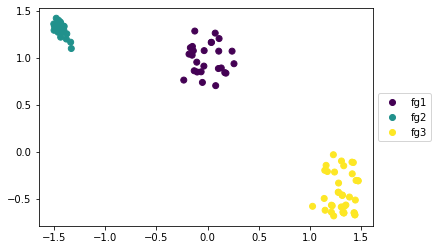

In [22]:
scatter = plt.scatter(attended_data[:,0],attended_data[:,1],c=labels_)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3"))

In [23]:
# scatter = plt.scatter(x[:,0],x[:,1],c=y)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
#            handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))

In [24]:
# print(max_values)
# sorted_values,_ = torch.sort(non_max_values,descending=True)
# sorted_values[0,0:20]

In [25]:
# print(max_values_1)
# sorted_values,_ = torch.sort(non_max_values_1,descending=True)
# sorted_values[0,0:20]

In [26]:
# print(max_values_2)
# sorted_values,_ = torch.sort(non_max_values_2,descending=True)
# sorted_values[0,0:20]

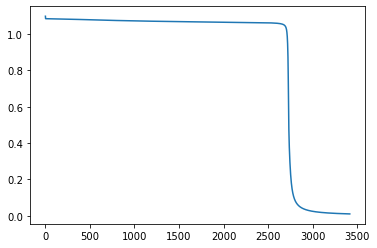

In [27]:
plt.plot(loss_list)

In [28]:
# attended_data

# hard attention

In [29]:
focus_net = Focus(input_dims = 2,attention="hard").double()
focus_net = focus_net.to(device)

classify = Classification(input_dims=2,output_dims=3).double()
classify = classify.to(device)

focus_net.apply(initialize_zeros_weights)
classify.apply(initialize_zeros_weights)
# parameters
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)


In [30]:
focus_net,classify,loss_list = train_attention_models(train_loader,focus_net,classify,
                           learning_rate=0.5,n_classes=3,nos_epochs=10000,attention="hard")

[1] loss: 1.099
[2] loss: 1.087
[3] loss: 1.086
[4] loss: 1.085
[5] loss: 1.085
[6] loss: 1.085
[7] loss: 1.085
[8] loss: 1.085
[9] loss: 1.085
[10] loss: 1.085
[11] loss: 1.085
[12] loss: 1.085
[13] loss: 1.085
[14] loss: 1.085
[15] loss: 1.085
[16] loss: 1.085
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085
[53] loss: 1.085
[54] loss: 1.085
[55] loss: 1.085
[56] loss: 1.085
[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] l

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[68] loss: 1.085
[69] loss: 1.085
[70] loss: 1.085
[71] loss: 1.085
[72] loss: 1.085
[73] loss: 1.085
[74] loss: 1.085
[75] loss: 1.085
[76] loss: 1.085
[77] loss: 1.085
[78] loss: 1.085
[79] loss: 1.085
[80] loss: 1.085
[81] loss: 1.085
[82] loss: 1.085
[83] loss: 1.085
[84] loss: 1.085
[85] loss: 1.085
[86] loss: 1.085
[87] loss: 1.085
[88] loss: 1.085
[89] loss: 1.085
[90] loss: 1.085
[91] loss: 1.085
[92] loss: 1.085
[93] loss: 1.085
[94] loss: 1.085
[95] loss: 1.085
[96] loss: 1.085
[97] loss: 1.085
[98] loss: 1.085
[99] loss: 1.085
[100] loss: 1.085
[101] loss: 1.085
[102] loss: 1.085
[103] loss: 1.085
[104] loss: 1.085
[105] loss: 1.085
[106] loss: 1.085
[107] loss: 1.085
[108] loss: 1.085
[109] loss: 1.085
[110] loss: 1.085
[111] loss: 1.085
[112] loss: 1.085
[113] loss: 1.085
[114] loss: 1.085
[115] loss: 1.085
[116] loss: 1.085
[117] loss: 1.085
[118] loss: 1.085
[119] loss: 1.085
[120] loss: 1.085
[121] loss: 1.085
[122] loss: 1.085
[123] loss: 1.085
[124] loss: 1.085
[125] 

[593] loss: 1.085
[594] loss: 1.085
[595] loss: 1.085
[596] loss: 1.085
[597] loss: 1.085
[598] loss: 1.085
[599] loss: 1.085
[600] loss: 1.085
[601] loss: 1.085
[602] loss: 1.085
[603] loss: 1.085
[604] loss: 1.085
[605] loss: 1.085
[606] loss: 1.085
[607] loss: 1.085
[608] loss: 1.085
[609] loss: 1.085
[610] loss: 1.085
[611] loss: 1.085
[612] loss: 1.085
[613] loss: 1.085
[614] loss: 1.085
[615] loss: 1.085
[616] loss: 1.085
[617] loss: 1.085
[618] loss: 1.085
[619] loss: 1.085
[620] loss: 1.085
[621] loss: 1.085
[622] loss: 1.085
[623] loss: 1.085
[624] loss: 1.085
[625] loss: 1.085
[626] loss: 1.085
[627] loss: 1.085
[628] loss: 1.085
[629] loss: 1.085
[630] loss: 1.085
[631] loss: 1.085
[632] loss: 1.085
[633] loss: 1.085
[634] loss: 1.085
[635] loss: 1.085
[636] loss: 1.085
[637] loss: 1.085
[638] loss: 1.085
[639] loss: 1.085
[640] loss: 1.085
[641] loss: 1.085
[642] loss: 1.085
[643] loss: 1.085
[644] loss: 1.085
[645] loss: 1.085
[646] loss: 1.085
[647] loss: 1.085
[648] loss

[1109] loss: 0.147
[1110] loss: 0.143
[1111] loss: 0.140
[1112] loss: 0.136
[1113] loss: 0.133
[1114] loss: 0.130
[1115] loss: 0.127
[1116] loss: 0.125
[1117] loss: 0.122
[1118] loss: 0.119
[1119] loss: 0.117
[1120] loss: 0.115
[1121] loss: 0.112
[1122] loss: 0.110
[1123] loss: 0.108
[1124] loss: 0.106
[1125] loss: 0.104
[1126] loss: 0.102
[1127] loss: 0.100
[1128] loss: 0.098
[1129] loss: 0.097
[1130] loss: 0.095
[1131] loss: 0.094
[1132] loss: 0.092
[1133] loss: 0.091
[1134] loss: 0.089
[1135] loss: 0.088
[1136] loss: 0.086
[1137] loss: 0.085
[1138] loss: 0.084
[1139] loss: 0.082
[1140] loss: 0.081
[1141] loss: 0.080
[1142] loss: 0.079
[1143] loss: 0.078
[1144] loss: 0.077
[1145] loss: 0.076
[1146] loss: 0.075
[1147] loss: 0.074
[1148] loss: 0.073
[1149] loss: 0.072
[1150] loss: 0.071
[1151] loss: 0.070
[1152] loss: 0.069
[1153] loss: 0.068
[1154] loss: 0.067
[1155] loss: 0.067
[1156] loss: 0.066
[1157] loss: 0.065
[1158] loss: 0.064
[1159] loss: 0.064
[1160] loss: 0.063
[1161] loss:

[1571] loss: 0.011
[1572] loss: 0.011
[1573] loss: 0.011
[1574] loss: 0.011
[1575] loss: 0.011
[1576] loss: 0.011
[1577] loss: 0.011
[1578] loss: 0.011
[1579] loss: 0.011
[1580] loss: 0.011
[1581] loss: 0.011
[1582] loss: 0.011
[1583] loss: 0.011
[1584] loss: 0.011
[1585] loss: 0.011
[1586] loss: 0.011
[1587] loss: 0.011
[1588] loss: 0.011
[1589] loss: 0.011
[1590] loss: 0.011
[1591] loss: 0.011
[1592] loss: 0.011
[1593] loss: 0.011
[1594] loss: 0.011
[1595] loss: 0.011
[1596] loss: 0.011
[1597] loss: 0.011
[1598] loss: 0.011
[1599] loss: 0.011
[1600] loss: 0.011
[1601] loss: 0.010
[1602] loss: 0.010
[1603] loss: 0.010
[1604] loss: 0.010
[1605] loss: 0.010
[1606] loss: 0.010
[1607] loss: 0.010
[1608] loss: 0.010
[1609] loss: 0.010
[1610] loss: 0.010
[1611] loss: 0.010
[1612] loss: 0.010
[1613] loss: 0.010
[1614] loss: 0.010
[1615] loss: 0.010
[1616] loss: 0.010
[1617] loss: 0.010
[1618] loss: 0.010
[1619] loss: 0.010
[1620] loss: 0.010
[1621] loss: 0.010
[1622] loss: 0.010
[1623] loss:

In [31]:
save_analysis(train_loader,test_loader,focus_net,classify,3) # ftpt ffpt ftpf ffpf

([100, 0, 0, 0], [1000, 0, 0, 0])

In [32]:
attended_data = []
labels_ = []
focus_net.eval()
classify.eval()
with torch.no_grad():
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        labels_.append(labels.numpy())
        # zero the parameter gradients
        alphas, avg_images = focus_net(inputs)
        max_values,_ = torch.max(alphas[labels==0],dim=1)
        non_max_values,_ = torch.topk(alphas[labels==0],k=99,largest=False)
        #print(alphas[np.arange(alphas.shape[0]),torch.argmax(alphas,dim=1)],torch.argmax(alphas,dim=1),fore_idx)
        outputs = torch.sigmoid(classify(avg_images))
        attended_data.append(avg_images.numpy())
#         loss = my_cross_entropy(outputs[:,0], labels.double(),alphas) 

In [33]:
attended_data = np.concatenate(attended_data,axis=0)
# labels_ = np.concatenate(labels_,axis=0)

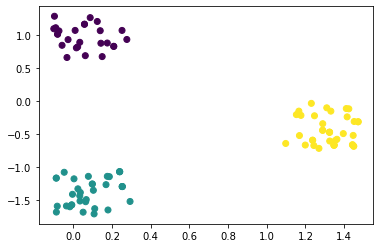

In [34]:
plt.scatter(attended_data[:,0],attended_data[:,1],c=labels_)

In [35]:
print(max_values)
sorted_values,_ = torch.sort(non_max_values,descending=True)
sorted_values[:,0:10]

tensor([0.9889, 0.9229, 0.9676, 0.9124, 0.9524, 0.9621, 0.9475, 0.9897, 0.9753,
        0.8571, 0.9780, 0.8921, 0.9689, 0.9703, 0.9607, 0.9542, 0.9868, 0.9875,
        0.9037, 0.9821, 0.9849, 0.8956, 0.9859, 0.9504, 0.9503, 0.9383],
       dtype=torch.float64)


tensor([[0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003,
         0.0003],
        [0.0031, 0.0031, 0.0028, 0.0028, 0.0028, 0.0027, 0.0027, 0.0026, 0.0024,
         0.0023],
        [0.0013, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0010, 0.0010,
         0.0010],
        [0.0032, 0.0032, 0.0029, 0.0028, 0.0025, 0.0025, 0.0025, 0.0025, 0.0024,
         0.0024],
        [0.0020, 0.0018, 0.0018, 0.0016, 0.0015, 0.0015, 0.0014, 0.0014, 0.0014,
         0.0014],
        [0.0014, 0.0013, 0.0012, 0.0012, 0.0012, 0.0012, 0.0011, 0.0011, 0.0010,
         0.0009],
        [0.0019, 0.0019, 0.0019, 0.0017, 0.0017, 0.0017, 0.0017, 0.0016, 0.0015,
         0.0015],
        [0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
         0.0003],
        [0.0010, 0.0010, 0.0009, 0.0008, 0.0008, 0.0008, 0.0008, 0.0007, 0.0007,
         0.0007],
        [0.0052, 0.0052, 0.0047, 0.0045, 0.0045, 0.0045, 0.0043, 0.0041, 0.0041,
         0.0038],
        [0

In [36]:
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[ 5.8009, -1.8112]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-2.3735,  3.2060],
        [-1.8601, -3.4176],
        [ 4.2336,  0.2115]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 1.6275, -0.3093, -1.3182], dtype=torch.float64, requires_grad=True)


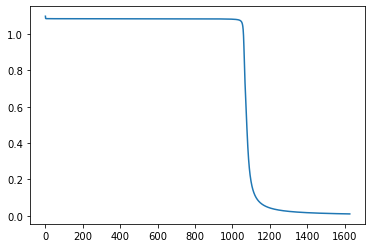

In [37]:
plt.plot(loss_list)

# train a max-margin classifier

In [38]:
fg_bg_labels = np.ones(y.shape)
fg_bg_labels[np.where(y==3)] = 0

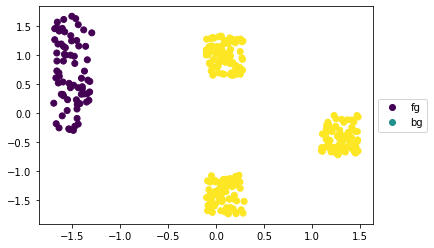

In [39]:
plt.scatter(x[:,0],x[:,1],c=fg_bg_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg","bg"))

In [40]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0,fit_intercept=True)
clf.fit(x,fg_bg_labels)

LinearSVC(random_state=0)

In [41]:
sum(clf.predict(x) == fg_bg_labels)

300

In [42]:
clf.coef_,clf.intercept_

(array([[ 1.49467446, -0.00920422]]), array([1.06334517]))

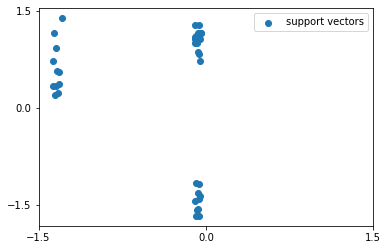

In [43]:
decision_function = clf.decision_function(x)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = x[support_vector_indices]
plt.scatter(support_vectors[:,0],support_vectors[:,1],label="support vectors")
plt.xticks([-1.5,0.0,1.5])
plt.yticks([-1.5,0.0,1.5])
plt.legend()


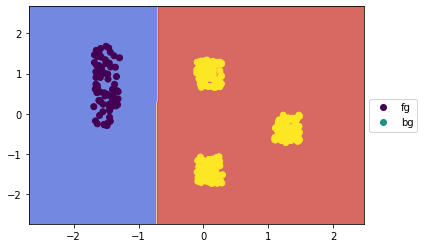

In [44]:
# create a mesh to plot in
h = 0.02
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x[:,0],x[:,1],c=fg_bg_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg","bg"))


In [45]:
beta = torch.tensor([0,0.01,0.02,0.04,0.08,0.16,0.32,0.50,0.64,1,1.28,2.56,5.12])
directions = torch.tensor([[1,0],[1/np.sqrt(2),1/np.sqrt(2)],[0,1],
              [-1/np.sqrt(2),1/np.sqrt(2)],[-1,0],[-1/np.sqrt(2),-1/np.sqrt(2)],[0,-1],[1/np.sqrt(2),-1/np.sqrt(2)]])

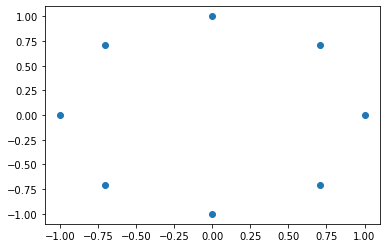

In [46]:
plt.scatter(directions[:,0],directions[:,1])

In [47]:
def generate_attended_data(trainloader,focus,focus_direction=None):
    attended_data = []
    attended_labels = []
    for i, data in  enumerate(trainloader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        if focus_direction is None:
            alphas, avg_data = focus(inputs)
        else:
            z = inputs
            batch = z.size(0)
            patches = z.size(1)
            dims = z.size(2)
            z = z.view(batch,patches,dims)
            alp1,ft1 = focus.helper(z)
            alp2,ft2 = focus_direction.helper(z)
            alp3 = alp1 + alp2
            alpha = F.softmax(alp3,dim=1)
            y = torch.sum(alpha*ft1,dim=1)
            alpha =alpha[:,:,0]
            avg_data = y
            
            
        attended_data.append(avg_data)
        attended_labels.append(labels)
    attended_data = torch.cat(attended_data,dim=0)
    attended_labels = torch.cat(attended_labels,dim=0)
    #plt.figure()
    #plt.scatter(attended_data[:,0],attended_data[:,1],c=attended_labels)
    return attended_data,attended_labels
        
    

In [48]:
def calculate_loss(data,labels,net,criterion):
    net.eval()
    with torch.no_grad():
        outputs = net(data)
        loss = criterion(outputs,labels)
    return loss.item()
        
        
        

In [49]:
def train_classification_model(attended_data,attended_labels, classify_model,
                               n_classes,test_list,learning_rate=0.01):
    nos_epochs = 300
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCELoss()
    optimizer_classify = optim.SGD(classify_model.parameters(), lr=learning_rate)#,  momentum=0.09)
    loss_list=[]
    test_loss_list = []
    #print("ddd",attended_data,attended_labels)
    #print("sss",test_list[0])
    
    with torch.no_grad():
        test_loss_epoch  = [] 
        epoch_loss = []
        
        # for train data at epoch zero
        outputs = classify_model(attended_data)
        loss = criterion(outputs,attended_labels)
        epoch_loss.append(loss.item())
        # for test data at epoch zero
        test_loss_epoch  = [] 
        for data in test_list:
            test_inputs,test_labels = data
            classify_model.eval()
            test_outputs = classify_model(test_inputs)
            test_loss = criterion(test_outputs,test_labels)
            test_loss_epoch.append(test_loss.item())
        test_loss_list.append(test_loss_epoch)
    loss_list.append(np.mean(epoch_loss))
        
    
    
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        test_loss_epoch  = [] 
        classify_model.train()
        # zero the parameter gradients
        optimizer_classify.zero_grad()
        outputs = classify_model(attended_data)
        #print(outputs.shape)
        # predicted values
        if n_classes > 2:
            _,predicted= torch.max(outputs,dim=1)
        else:
            predicted = (outputs.data[:,0]>0.5).type(torch.int64)
        loss = criterion(outputs,attended_labels)
        loss.backward()
        optimizer_classify.step()
        
        loss_ = calculate_loss(attended_data,attended_labels,classify_model,criterion)
        epoch_loss.append(loss_)
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        # loss for test list, At every epoch for every direction perform forward pass and calculate loss
        for data in test_list:
            test_inputs,test_labels = data
            test_loss = calculate_loss(test_inputs,test_labels,classify_model,criterion)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)    
        if(np.mean(epoch_loss) <= 0.01):
            break    
    print('Finished Training')
    print(len(loss_list),len(test_loss_list))
    return classify_model,loss_list,test_loss_list
    
    

In [50]:
weight = torch.tensor([[1.49467446, -0.00920422]],dtype=torch.float64)
weight = weight/torch.linalg.norm(weight)
print(torch.linalg.norm(weight))
loss_beta = []
test_loss_beta = []
for beta_ in beta:
    focus_net = Focus(input_dims = 2,attention="soft").double()
    focus_net = focus_net.to(device)
    focus_net.fc1.weight.data = beta_*weight
    focus_net.fc1.weight.requires_grad = False

    classify = Classification(input_dims=2,output_dims=3).double()
    classify.apply(initialize_zeros_weights)
    classify = classify.to(device)

    print("Parameters")
    
    for params in focus_net.named_parameters():
        print(params)
    
    # attended data for focus model 
    f_attended_data,f_labels = generate_attended_data(train_loader,focus_net)
    
    # test attended data for focus model with 8 directions
    test_attended_data = []
    test_attended_data.append([f_attended_data,f_labels])
    
    for u in directions:
        focus_net_direction = Focus(input_dims = 2,attention="soft").double()
        focus_net_direction = focus_net_direction.to(device)
        focus_net_direction.fc1.weight.data = 0.01*u[None,:]
        focus_net_direction.fc1.weight.requires_grad = False
        d_attended_data,d_labels = generate_attended_data(train_loader,focus_net,focus_net_direction)

        test_attended_data.append([d_attended_data,d_labels])

        
        
    
    _,loss_list,test_loss_list = train_classification_model(f_attended_data,f_labels,classify,
                                             n_classes=3,test_list=test_attended_data,learning_rate=0.5)
    
    test_loss_list = np.array(test_loss_list)
    
    loss_beta.append(loss_list)
    test_loss_beta.append(test_loss_list)
        
    

    

tensor(1.0000, dtype=torch.float64)
Parameters
('fc1.weight', Parameter containing:
tensor([[0., -0.]], dtype=torch.float64))
[1] loss: 1.087
[2] loss: 1.086
[3] loss: 1.085
[4] loss: 1.085
[5] loss: 1.085
[6] loss: 1.085
[7] loss: 1.085
[8] loss: 1.085
[9] loss: 1.085
[10] loss: 1.085
[11] loss: 1.085
[12] loss: 1.085
[13] loss: 1.085
[14] loss: 1.085
[15] loss: 1.085
[16] loss: 1.085
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085

[53] loss: 1.085
[54] loss: 1.085
[55] loss: 1.085
[56] loss: 1.085
[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] loss: 1.085
[61] loss: 1.085
[62] loss: 1.085
[63] loss: 1.085
[64] loss: 1.085
[65] loss: 1.085
[66] loss: 1.085
[67] loss: 1.085
[68] loss: 1.085
[69] loss: 1.085
[70] loss: 1.085
[71] loss: 1.085
[72] loss: 1.085
[73] loss: 1.085
[74] loss: 1.085
[75] loss: 1.085
[76] loss: 1.085
[77] loss: 1.085
[78] loss: 1.085
[79] loss: 1.085
[80] loss: 1.085
[81] loss: 1.085
[82] loss: 1.085
[83] loss: 1.085
[84] loss: 1.085
[85] loss: 1.085
[86] loss: 1.085
[87] loss: 1.085
[88] loss: 1.085
[89] loss: 1.085
[90] loss: 1.085
[91] loss: 1.085
[92] loss: 1.085
[93] loss: 1.085
[94] loss: 1.085
[95] loss: 1.085
[96] loss: 1.085
[97] loss: 1.085
[98] loss: 1.085
[99] loss: 1.085
[100] loss: 1.085
[101] loss: 1.085
[102] loss: 1.085
[103] loss: 1.085
[104] loss: 1.085
[105] loss: 1.085
[106] loss: 1.085
[107] loss: 1.085
[108] loss: 1.085
[109] loss: 1.085
[110] loss: 1.085
[11

[96] loss: 1.085
[97] loss: 1.085
[98] loss: 1.085
[99] loss: 1.085
[100] loss: 1.085
[101] loss: 1.085
[102] loss: 1.085
[103] loss: 1.085
[104] loss: 1.085
[105] loss: 1.085
[106] loss: 1.085
[107] loss: 1.085
[108] loss: 1.085
[109] loss: 1.085
[110] loss: 1.085
[111] loss: 1.085
[112] loss: 1.085
[113] loss: 1.085
[114] loss: 1.085
[115] loss: 1.085
[116] loss: 1.085
[117] loss: 1.085
[118] loss: 1.085
[119] loss: 1.085
[120] loss: 1.085
[121] loss: 1.085
[122] loss: 1.085
[123] loss: 1.085
[124] loss: 1.085
[125] loss: 1.085
[126] loss: 1.085
[127] loss: 1.085
[128] loss: 1.085
[129] loss: 1.085
[130] loss: 1.085
[131] loss: 1.085
[132] loss: 1.085
[133] loss: 1.085
[134] loss: 1.085
[135] loss: 1.085
[136] loss: 1.085
[137] loss: 1.084
[138] loss: 1.084
[139] loss: 1.084
[140] loss: 1.084
[141] loss: 1.084
[142] loss: 1.084
[143] loss: 1.084
[144] loss: 1.084
[145] loss: 1.084
[146] loss: 1.084
[147] loss: 1.084
[148] loss: 1.084
[149] loss: 1.084
[150] loss: 1.084
[151] loss: 1.

[111] loss: 1.083
[112] loss: 1.083
[113] loss: 1.083
[114] loss: 1.083
[115] loss: 1.083
[116] loss: 1.083
[117] loss: 1.083
[118] loss: 1.083
[119] loss: 1.083
[120] loss: 1.083
[121] loss: 1.083
[122] loss: 1.083
[123] loss: 1.083
[124] loss: 1.083
[125] loss: 1.083
[126] loss: 1.083
[127] loss: 1.083
[128] loss: 1.083
[129] loss: 1.083
[130] loss: 1.083
[131] loss: 1.083
[132] loss: 1.082
[133] loss: 1.082
[134] loss: 1.082
[135] loss: 1.082
[136] loss: 1.082
[137] loss: 1.082
[138] loss: 1.082
[139] loss: 1.082
[140] loss: 1.082
[141] loss: 1.082
[142] loss: 1.082
[143] loss: 1.082
[144] loss: 1.082
[145] loss: 1.082
[146] loss: 1.082
[147] loss: 1.082
[148] loss: 1.082
[149] loss: 1.082
[150] loss: 1.082
[151] loss: 1.082
[152] loss: 1.082
[153] loss: 1.082
[154] loss: 1.082
[155] loss: 1.082
[156] loss: 1.082
[157] loss: 1.082
[158] loss: 1.082
[159] loss: 1.082
[160] loss: 1.082
[161] loss: 1.082
[162] loss: 1.082
[163] loss: 1.082
[164] loss: 1.082
[165] loss: 1.082
[166] loss

[175] loss: 1.048
[176] loss: 1.048
[177] loss: 1.048
[178] loss: 1.048
[179] loss: 1.048
[180] loss: 1.047
[181] loss: 1.047
[182] loss: 1.047
[183] loss: 1.047
[184] loss: 1.046
[185] loss: 1.046
[186] loss: 1.046
[187] loss: 1.046
[188] loss: 1.046
[189] loss: 1.045
[190] loss: 1.045
[191] loss: 1.045
[192] loss: 1.045
[193] loss: 1.045
[194] loss: 1.044
[195] loss: 1.044
[196] loss: 1.044
[197] loss: 1.044
[198] loss: 1.043
[199] loss: 1.043
[200] loss: 1.043
[201] loss: 1.043
[202] loss: 1.043
[203] loss: 1.042
[204] loss: 1.042
[205] loss: 1.042
[206] loss: 1.042
[207] loss: 1.042
[208] loss: 1.041
[209] loss: 1.041
[210] loss: 1.041
[211] loss: 1.041
[212] loss: 1.040
[213] loss: 1.040
[214] loss: 1.040
[215] loss: 1.040
[216] loss: 1.040
[217] loss: 1.039
[218] loss: 1.039
[219] loss: 1.039
[220] loss: 1.039
[221] loss: 1.039
[222] loss: 1.038
[223] loss: 1.038
[224] loss: 1.038
[225] loss: 1.038
[226] loss: 1.038
[227] loss: 1.037
[228] loss: 1.037
[229] loss: 1.037
[230] loss

[43] loss: 0.815
[44] loss: 0.810
[45] loss: 0.806
[46] loss: 0.802
[47] loss: 0.797
[48] loss: 0.793
[49] loss: 0.789
[50] loss: 0.785
[51] loss: 0.781
[52] loss: 0.777
[53] loss: 0.773
[54] loss: 0.769
[55] loss: 0.766
[56] loss: 0.762
[57] loss: 0.758
[58] loss: 0.755
[59] loss: 0.751
[60] loss: 0.748
[61] loss: 0.744
[62] loss: 0.741
[63] loss: 0.737
[64] loss: 0.734
[65] loss: 0.731
[66] loss: 0.728
[67] loss: 0.724
[68] loss: 0.721
[69] loss: 0.718
[70] loss: 0.715
[71] loss: 0.712
[72] loss: 0.709
[73] loss: 0.706
[74] loss: 0.703
[75] loss: 0.700
[76] loss: 0.698
[77] loss: 0.695
[78] loss: 0.692
[79] loss: 0.689
[80] loss: 0.687
[81] loss: 0.684
[82] loss: 0.681
[83] loss: 0.679
[84] loss: 0.676
[85] loss: 0.674
[86] loss: 0.671
[87] loss: 0.669
[88] loss: 0.666
[89] loss: 0.664
[90] loss: 0.662
[91] loss: 0.659
[92] loss: 0.657
[93] loss: 0.655
[94] loss: 0.653
[95] loss: 0.650
[96] loss: 0.648
[97] loss: 0.646
[98] loss: 0.644
[99] loss: 0.642
[100] loss: 0.640
[101] loss: 0

[116] loss: 0.032
[117] loss: 0.032
[118] loss: 0.032
[119] loss: 0.031
[120] loss: 0.031
[121] loss: 0.031
[122] loss: 0.031
[123] loss: 0.030
[124] loss: 0.030
[125] loss: 0.030
[126] loss: 0.030
[127] loss: 0.029
[128] loss: 0.029
[129] loss: 0.029
[130] loss: 0.029
[131] loss: 0.029
[132] loss: 0.028
[133] loss: 0.028
[134] loss: 0.028
[135] loss: 0.028
[136] loss: 0.028
[137] loss: 0.027
[138] loss: 0.027
[139] loss: 0.027
[140] loss: 0.027
[141] loss: 0.027
[142] loss: 0.026
[143] loss: 0.026
[144] loss: 0.026
[145] loss: 0.026
[146] loss: 0.026
[147] loss: 0.026
[148] loss: 0.025
[149] loss: 0.025
[150] loss: 0.025
[151] loss: 0.025
[152] loss: 0.025
[153] loss: 0.025
[154] loss: 0.024
[155] loss: 0.024
[156] loss: 0.024
[157] loss: 0.024
[158] loss: 0.024
[159] loss: 0.024
[160] loss: 0.024
[161] loss: 0.023
[162] loss: 0.023
[163] loss: 0.023
[164] loss: 0.023
[165] loss: 0.023
[166] loss: 0.023
[167] loss: 0.023
[168] loss: 0.023
[169] loss: 0.022
[170] loss: 0.022
[171] loss

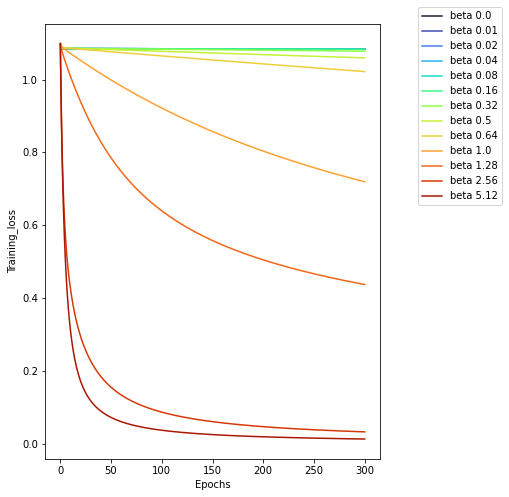

In [51]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(loss_beta):
    plt.plot(j,label ="beta "+str(np.around(beta[i].item(),3)),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("cin_train_loss_1.png",bbox_inches='tight')

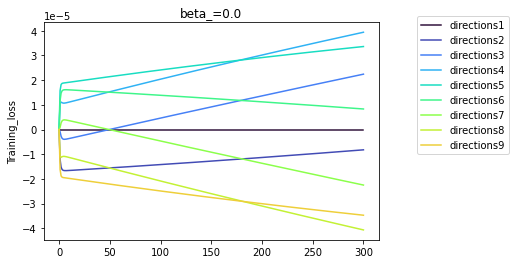

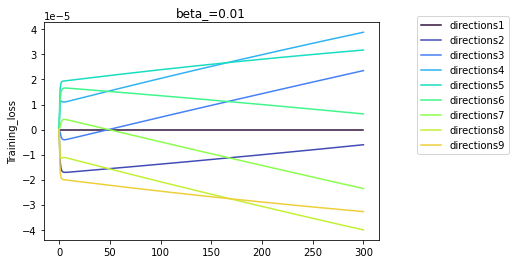

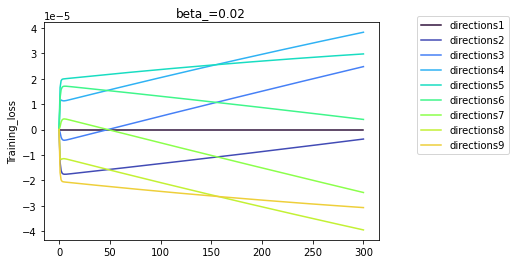

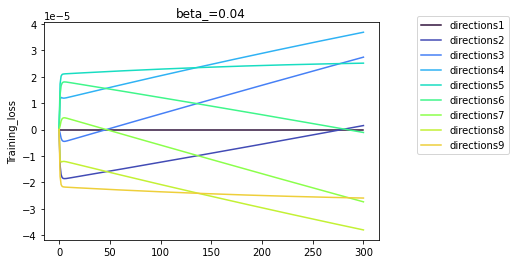

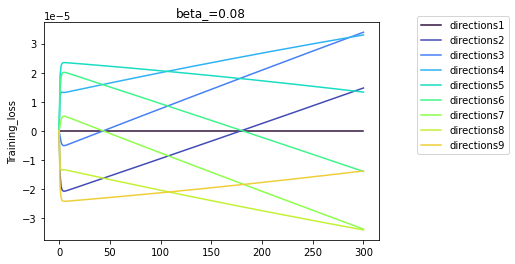

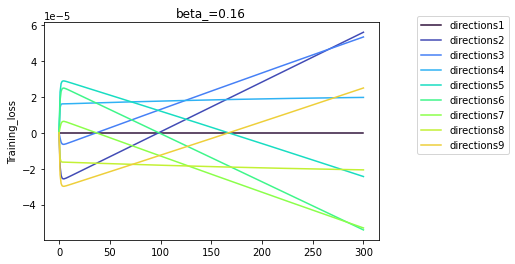

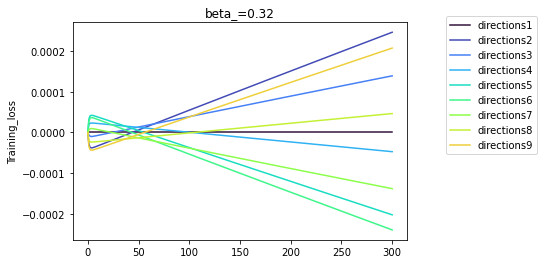

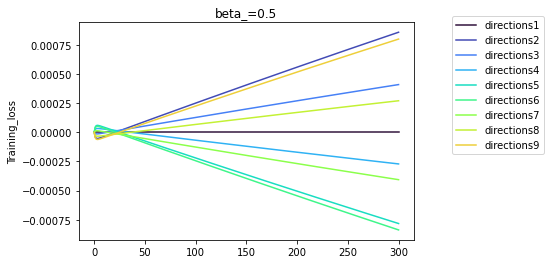

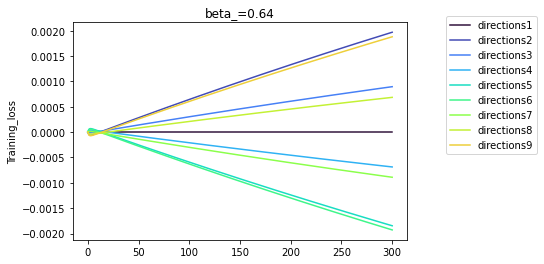

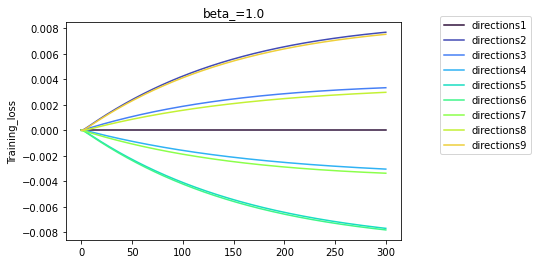

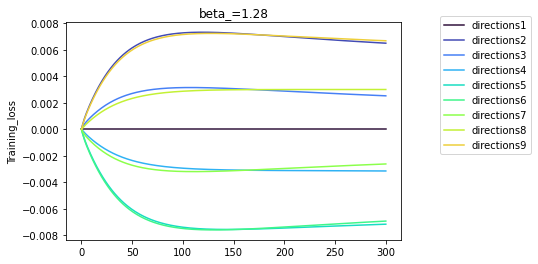

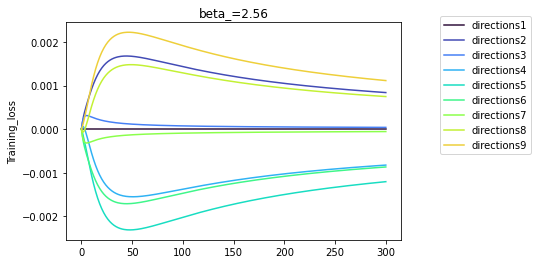

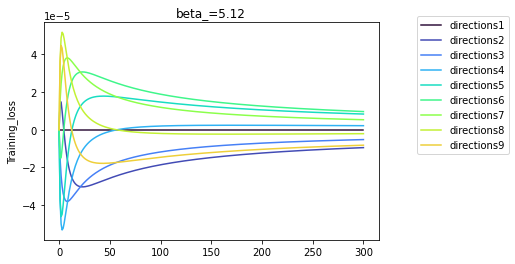

In [52]:
for j in range(len(beta)):
    plt.figure()
    for i in range(len(directions)+1):
        temp = np.array(loss_beta[j]) - test_loss_beta[j][:,i]
        plt.plot(temp,label ="directions"+str(i+1),color = cm(i*20))
        plt.ylabel("Training_loss")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.title("beta_="+str(np.around(beta[j].item(),3)))
        plt.savefig("cin_train_loss_1_loss_beta_"+str(j)+".png",bbox_inches='tight')

In [53]:
def hard_attention_generate_attended_data(trainloader,focus,focus_direction=None):
    
    mosaic_data = [] 
    attended_labels = []
    alpha_data = []
    
    for i, data in  enumerate(trainloader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        if focus_direction is None:
            alpha, avg_data = focus(inputs)
        else:
            z = inputs
            batch = z.size(0)
            patches = z.size(1)
            dims = z.size(2)
            z = z.view(batch,patches,dims)
            alp1,ft1 = focus.helper(z)
            alp2,ft2 = focus_direction.helper(z)
            alp3 = alp1 + alp2
            alpha = F.softmax(alp3,dim=1)[:,:,0]  
            #print(alpha.shape)
        mosaic_data.append(inputs)
        attended_labels.append(labels)
        alpha_data.append(alpha)
    mosaic_data = torch.cat(mosaic_data,dim=0)
    attended_labels = torch.cat(attended_labels,dim=0)
    alpha_data = torch.cat(alpha_data,dim=0)
    return mosaic_data,attended_labels,alpha_data
        

In [54]:
def hard_attention_calculate_loss(data,labels,alphas,net,criterion,train_mode=True):
    if train_mode:
        net.train()
        outputs = net(data)
        batch = outputs.size(0)
        patches = outputs.size(1)
        classes = outputs.size(2)
        
        outputs = torch.reshape(outputs,(batch*patches,classes))
        labels = labels.repeat_interleave(patches)
        loss = criterion(outputs,labels)
        loss = torch.reshape(loss,(batch,patches))
        loss = torch.mul(alphas,loss)
        loss = torch.sum(loss,dim=1)
        loss = torch.mean(loss)
        return loss
    else:  
        net.eval()
        with torch.no_grad():
            outputs = net(data)
            batch = outputs.size(0)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes))
            labels = labels.repeat_interleave(patches)
            loss = criterion(outputs,labels)
            loss = torch.reshape(loss,(batch,patches))
            loss = torch.mul(alphas,loss)
            loss = torch.sum(loss,dim=1)
            loss = torch.mean(loss)
            return loss.item()
        

In [55]:
def train_hard_attention_classification_model(mosaic_data,mosaic_labels,alphas,classify_model,
                               n_classes,test_list,learning_rate=0.01):
    nos_epochs = 300
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss(reduction="none")
    else:
        criterion = nn.BCELoss(reduction="none")
    optimizer_classify = optim.SGD(classify_model.parameters(), lr=learning_rate)#,  momentum=0.09)
    loss_list=[]
    test_loss_list = []
    #print("ddd",attended_data,attended_labels)
    #print("sss",test_list[0])
    with torch.no_grad():
        test_loss_epoch  = [] 
        epoch_loss = []
        
        # for train data at epoch zero
        loss = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                             alphas,classify_model,criterion,train_mode=False)
        epoch_loss.append(loss)
        # for test data at epoch zero
        test_loss_epoch  = [] 
        for data in test_list:
            test_mosaic_data,test_mosaic_labels,test_alphas = data
            test_loss = hard_attention_calculate_loss(test_mosaic_data,test_mosaic_labels,
                                                      test_alphas,classify_model,criterion,train_mode=False)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)
    loss_list.append(np.mean(epoch_loss))
        
    
    
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        test_loss_epoch  = [] 
        classify_model.train()
        # zero the parameter gradients
        optimizer_classify.zero_grad()
        #outputs = classify_model(mosaic_data)
        #print(outputs.shape)
        # predicted values
        if n_classes > 2:
            _,predicted= torch.max(outputs,dim=1)
        else:
            predicted = (outputs.data[:,0]>0.5).type(torch.int64)
        loss = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                             alphas,classify_model,criterion,train_mode=True)
        loss.backward()
        optimizer_classify.step()
        
        loss_ = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                              alphas,classify_model,criterion,train_mode=False)
        epoch_loss.append(loss_)
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        # loss for test list, At every epoch for every direction perform forward pass and calculate loss
        for data in test_list:
            test_mosaic_data,test_mosaic_labels,test_alphas = data
            test_loss = hard_attention_calculate_loss(test_mosaic_data,test_mosaic_labels,test_alphas,
                                       classify_model,criterion,train_mode=False)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)    
        if(np.mean(epoch_loss) <= 0.01):
            break    
    print('Finished Training')
    print(len(loss_list),len(test_loss_list))
    return classify_model,loss_list,test_loss_list

In [56]:
weight = torch.tensor([[1.49467446, -0.00920422]],dtype=torch.float64)
weight = weight/torch.linalg.norm(weight)
print(torch.linalg.norm(weight))
loss_beta = []
test_loss_beta = []
for beta_ in beta:
    focus_net = Focus(input_dims = 2,attention="hard").double()
    focus_net = focus_net.to(device)
    focus_net.fc1.weight.data = beta_*weight
    focus_net.fc1.weight.requires_grad = False
    

    
    classify = Classification(input_dims=2,output_dims=3).double()
    classify.apply(initialize_zeros_weights)
    classify = classify.to(device)
    

    
    print("Parameters")
    
    for params in focus_net.named_parameters():
        print(params)
    
    # attended data for focus model 
    f_mosaic_data,f_mosaic_labels,f_alphas =  hard_attention_generate_attended_data(train_loader,focus_net)
    
    # test attended data for focus model with 8 directions
    test_attended_data = []
    test_attended_data.append([f_mosaic_data,f_mosaic_labels,f_alphas])
    
    for u in directions:
        focus_net_direction = Focus(input_dims = 2,attention="hard").double()
        focus_net_direction = focus_net_direction.to(device)
        focus_net_direction.fc1.weight.data = 0.01*u[None,:]
        focus_net_direction.fc1.weight.requires_grad = False
        d_mosaic_data,d_mosaic_labels,d_alphas =  hard_attention_generate_attended_data(train_loader,
                                                                                        focus_net,focus_net_direction)

        test_attended_data.append([d_mosaic_data,d_mosaic_labels,d_alphas ])

        
        
    
    _,loss_list,test_loss_list = train_hard_attention_classification_model(f_mosaic_data,f_mosaic_labels,
                                                                          f_alphas,classify,n_classes=3,
                                                                          test_list=test_attended_data,
                                                                          learning_rate=0.5)
    
    test_loss_list = np.array(test_loss_list)
    
    loss_beta.append(loss_list)
    test_loss_beta.append(test_loss_list)

tensor(1.0000, dtype=torch.float64)
Parameters
('fc1.weight', Parameter containing:
tensor([[0., -0.]], dtype=torch.float64))
[1] loss: 1.087
[2] loss: 1.086
[3] loss: 1.085
[4] loss: 1.085
[5] loss: 1.085
[6] loss: 1.085
[7] loss: 1.085
[8] loss: 1.085
[9] loss: 1.085
[10] loss: 1.085
[11] loss: 1.085
[12] loss: 1.085
[13] loss: 1.085
[14] loss: 1.085
[15] loss: 1.085
[16] loss: 1.085
[17] loss: 1.085
[18] loss: 1.085
[19] loss: 1.085
[20] loss: 1.085
[21] loss: 1.085
[22] loss: 1.085
[23] loss: 1.085
[24] loss: 1.085
[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085

[166] loss: 1.085
[167] loss: 1.085
[168] loss: 1.085
[169] loss: 1.085
[170] loss: 1.085
[171] loss: 1.085
[172] loss: 1.085
[173] loss: 1.085
[174] loss: 1.085
[175] loss: 1.085
[176] loss: 1.085
[177] loss: 1.085
[178] loss: 1.085
[179] loss: 1.085
[180] loss: 1.085
[181] loss: 1.085
[182] loss: 1.085
[183] loss: 1.085
[184] loss: 1.085
[185] loss: 1.085
[186] loss: 1.085
[187] loss: 1.085
[188] loss: 1.085
[189] loss: 1.085
[190] loss: 1.085
[191] loss: 1.085
[192] loss: 1.085
[193] loss: 1.085
[194] loss: 1.085
[195] loss: 1.085
[196] loss: 1.085
[197] loss: 1.085
[198] loss: 1.085
[199] loss: 1.085
[200] loss: 1.085
[201] loss: 1.085
[202] loss: 1.085
[203] loss: 1.085
[204] loss: 1.085
[205] loss: 1.085
[206] loss: 1.085
[207] loss: 1.085
[208] loss: 1.085
[209] loss: 1.085
[210] loss: 1.085
[211] loss: 1.085
[212] loss: 1.085
[213] loss: 1.085
[214] loss: 1.085
[215] loss: 1.085
[216] loss: 1.085
[217] loss: 1.085
[218] loss: 1.085
[219] loss: 1.085
[220] loss: 1.085
[221] loss

[25] loss: 1.085
[26] loss: 1.085
[27] loss: 1.085
[28] loss: 1.085
[29] loss: 1.085
[30] loss: 1.085
[31] loss: 1.085
[32] loss: 1.085
[33] loss: 1.085
[34] loss: 1.085
[35] loss: 1.085
[36] loss: 1.085
[37] loss: 1.085
[38] loss: 1.085
[39] loss: 1.085
[40] loss: 1.085
[41] loss: 1.085
[42] loss: 1.085
[43] loss: 1.085
[44] loss: 1.085
[45] loss: 1.085
[46] loss: 1.085
[47] loss: 1.085
[48] loss: 1.085
[49] loss: 1.085
[50] loss: 1.085
[51] loss: 1.085
[52] loss: 1.085
[53] loss: 1.085
[54] loss: 1.085
[55] loss: 1.085
[56] loss: 1.085
[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] loss: 1.085
[61] loss: 1.085
[62] loss: 1.085
[63] loss: 1.085
[64] loss: 1.085
[65] loss: 1.085
[66] loss: 1.085
[67] loss: 1.085
[68] loss: 1.085
[69] loss: 1.085
[70] loss: 1.085
[71] loss: 1.085
[72] loss: 1.085
[73] loss: 1.085
[74] loss: 1.085
[75] loss: 1.085
[76] loss: 1.085
[77] loss: 1.085
[78] loss: 1.085
[79] loss: 1.085
[80] loss: 1.085
[81] loss: 1.085
[82] loss: 1.085
[83] loss: 1.0

[205] loss: 1.085
[206] loss: 1.085
[207] loss: 1.085
[208] loss: 1.085
[209] loss: 1.085
[210] loss: 1.085
[211] loss: 1.085
[212] loss: 1.085
[213] loss: 1.085
[214] loss: 1.085
[215] loss: 1.085
[216] loss: 1.085
[217] loss: 1.085
[218] loss: 1.085
[219] loss: 1.085
[220] loss: 1.085
[221] loss: 1.085
[222] loss: 1.085
[223] loss: 1.085
[224] loss: 1.085
[225] loss: 1.085
[226] loss: 1.085
[227] loss: 1.085
[228] loss: 1.085
[229] loss: 1.085
[230] loss: 1.085
[231] loss: 1.085
[232] loss: 1.085
[233] loss: 1.085
[234] loss: 1.085
[235] loss: 1.085
[236] loss: 1.085
[237] loss: 1.085
[238] loss: 1.085
[239] loss: 1.085
[240] loss: 1.085
[241] loss: 1.085
[242] loss: 1.085
[243] loss: 1.085
[244] loss: 1.085
[245] loss: 1.085
[246] loss: 1.085
[247] loss: 1.085
[248] loss: 1.085
[249] loss: 1.085
[250] loss: 1.085
[251] loss: 1.085
[252] loss: 1.085
[253] loss: 1.085
[254] loss: 1.085
[255] loss: 1.085
[256] loss: 1.085
[257] loss: 1.085
[258] loss: 1.085
[259] loss: 1.085
[260] loss

[57] loss: 1.085
[58] loss: 1.085
[59] loss: 1.085
[60] loss: 1.085
[61] loss: 1.084
[62] loss: 1.084
[63] loss: 1.084
[64] loss: 1.084
[65] loss: 1.084
[66] loss: 1.084
[67] loss: 1.084
[68] loss: 1.084
[69] loss: 1.084
[70] loss: 1.084
[71] loss: 1.084
[72] loss: 1.084
[73] loss: 1.084
[74] loss: 1.084
[75] loss: 1.084
[76] loss: 1.084
[77] loss: 1.084
[78] loss: 1.084
[79] loss: 1.084
[80] loss: 1.084
[81] loss: 1.084
[82] loss: 1.084
[83] loss: 1.084
[84] loss: 1.084
[85] loss: 1.084
[86] loss: 1.084
[87] loss: 1.084
[88] loss: 1.084
[89] loss: 1.084
[90] loss: 1.084
[91] loss: 1.084
[92] loss: 1.084
[93] loss: 1.084
[94] loss: 1.084
[95] loss: 1.084
[96] loss: 1.084
[97] loss: 1.084
[98] loss: 1.084
[99] loss: 1.084
[100] loss: 1.084
[101] loss: 1.084
[102] loss: 1.084
[103] loss: 1.084
[104] loss: 1.084
[105] loss: 1.084
[106] loss: 1.084
[107] loss: 1.084
[108] loss: 1.084
[109] loss: 1.084
[110] loss: 1.084
[111] loss: 1.084
[112] loss: 1.084
[113] loss: 1.084
[114] loss: 1.084

[230] loss: 1.081
[231] loss: 1.081
[232] loss: 1.081
[233] loss: 1.081
[234] loss: 1.081
[235] loss: 1.081
[236] loss: 1.081
[237] loss: 1.081
[238] loss: 1.081
[239] loss: 1.081
[240] loss: 1.081
[241] loss: 1.081
[242] loss: 1.081
[243] loss: 1.081
[244] loss: 1.081
[245] loss: 1.081
[246] loss: 1.081
[247] loss: 1.081
[248] loss: 1.081
[249] loss: 1.081
[250] loss: 1.081
[251] loss: 1.081
[252] loss: 1.081
[253] loss: 1.081
[254] loss: 1.081
[255] loss: 1.081
[256] loss: 1.081
[257] loss: 1.081
[258] loss: 1.081
[259] loss: 1.081
[260] loss: 1.081
[261] loss: 1.081
[262] loss: 1.081
[263] loss: 1.081
[264] loss: 1.081
[265] loss: 1.081
[266] loss: 1.081
[267] loss: 1.081
[268] loss: 1.081
[269] loss: 1.081
[270] loss: 1.081
[271] loss: 1.081
[272] loss: 1.081
[273] loss: 1.081
[274] loss: 1.081
[275] loss: 1.081
[276] loss: 1.081
[277] loss: 1.081
[278] loss: 1.081
[279] loss: 1.081
[280] loss: 1.081
[281] loss: 1.081
[282] loss: 1.081
[283] loss: 1.081
[284] loss: 1.081
[285] loss

[89] loss: 1.056
[90] loss: 1.056
[91] loss: 1.056
[92] loss: 1.056
[93] loss: 1.056
[94] loss: 1.056
[95] loss: 1.056
[96] loss: 1.056
[97] loss: 1.056
[98] loss: 1.056
[99] loss: 1.056
[100] loss: 1.056
[101] loss: 1.056
[102] loss: 1.056
[103] loss: 1.056
[104] loss: 1.056
[105] loss: 1.056
[106] loss: 1.056
[107] loss: 1.056
[108] loss: 1.056
[109] loss: 1.056
[110] loss: 1.056
[111] loss: 1.056
[112] loss: 1.056
[113] loss: 1.056
[114] loss: 1.056
[115] loss: 1.056
[116] loss: 1.056
[117] loss: 1.056
[118] loss: 1.056
[119] loss: 1.056
[120] loss: 1.056
[121] loss: 1.056
[122] loss: 1.056
[123] loss: 1.056
[124] loss: 1.056
[125] loss: 1.056
[126] loss: 1.056
[127] loss: 1.056
[128] loss: 1.056
[129] loss: 1.056
[130] loss: 1.056
[131] loss: 1.056
[132] loss: 1.056
[133] loss: 1.056
[134] loss: 1.056
[135] loss: 1.056
[136] loss: 1.056
[137] loss: 1.056
[138] loss: 1.056
[139] loss: 1.056
[140] loss: 1.056
[141] loss: 1.056
[142] loss: 1.056
[143] loss: 1.056
[144] loss: 1.056
[14

[249] loss: 1.016
[250] loss: 1.016
[251] loss: 1.016
[252] loss: 1.016
[253] loss: 1.016
[254] loss: 1.016
[255] loss: 1.016
[256] loss: 1.016
[257] loss: 1.016
[258] loss: 1.016
[259] loss: 1.016
[260] loss: 1.016
[261] loss: 1.016
[262] loss: 1.016
[263] loss: 1.016
[264] loss: 1.016
[265] loss: 1.016
[266] loss: 1.016
[267] loss: 1.016
[268] loss: 1.016
[269] loss: 1.016
[270] loss: 1.016
[271] loss: 1.016
[272] loss: 1.016
[273] loss: 1.016
[274] loss: 1.016
[275] loss: 1.016
[276] loss: 1.016
[277] loss: 1.016
[278] loss: 1.016
[279] loss: 1.016
[280] loss: 1.016
[281] loss: 1.016
[282] loss: 1.016
[283] loss: 1.016
[284] loss: 1.016
[285] loss: 1.016
[286] loss: 1.016
[287] loss: 1.016
[288] loss: 1.016
[289] loss: 1.016
[290] loss: 1.016
[291] loss: 1.016
[292] loss: 1.016
[293] loss: 1.016
[294] loss: 1.016
[295] loss: 1.016
[296] loss: 1.016
[297] loss: 1.016
[298] loss: 1.016
[299] loss: 1.016
[300] loss: 1.016
Finished Training
301 301
Parameters
('fc1.weight', Parameter co

[110] loss: 0.071
[111] loss: 0.070
[112] loss: 0.070
[113] loss: 0.070
[114] loss: 0.069
[115] loss: 0.069
[116] loss: 0.069
[117] loss: 0.069
[118] loss: 0.068
[119] loss: 0.068
[120] loss: 0.068
[121] loss: 0.068
[122] loss: 0.067
[123] loss: 0.067
[124] loss: 0.067
[125] loss: 0.067
[126] loss: 0.067
[127] loss: 0.066
[128] loss: 0.066
[129] loss: 0.066
[130] loss: 0.066
[131] loss: 0.065
[132] loss: 0.065
[133] loss: 0.065
[134] loss: 0.065
[135] loss: 0.065
[136] loss: 0.065
[137] loss: 0.064
[138] loss: 0.064
[139] loss: 0.064
[140] loss: 0.064
[141] loss: 0.064
[142] loss: 0.063
[143] loss: 0.063
[144] loss: 0.063
[145] loss: 0.063
[146] loss: 0.063
[147] loss: 0.063
[148] loss: 0.062
[149] loss: 0.062
[150] loss: 0.062
[151] loss: 0.062
[152] loss: 0.062
[153] loss: 0.062
[154] loss: 0.062
[155] loss: 0.061
[156] loss: 0.061
[157] loss: 0.061
[158] loss: 0.061
[159] loss: 0.061
[160] loss: 0.061
[161] loss: 0.061
[162] loss: 0.060
[163] loss: 0.060
[164] loss: 0.060
[165] loss

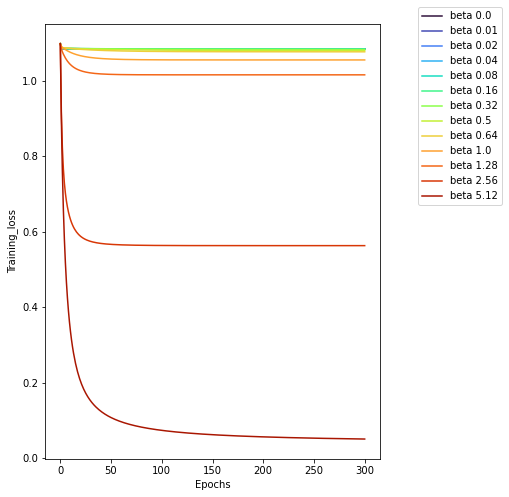

In [57]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(loss_beta):
    plt.plot(j,label ="beta "+str(np.around(beta[i].item(),3)),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("sin_train_loss_1.png",bbox_inches='tight')

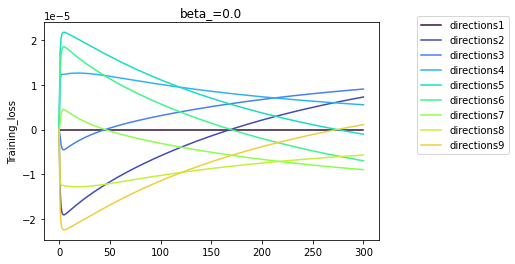

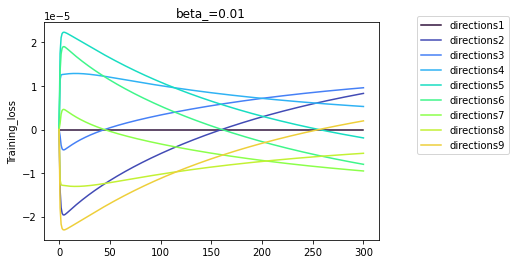

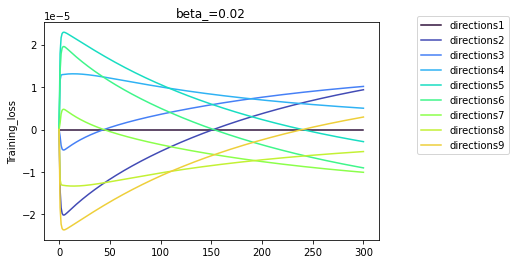

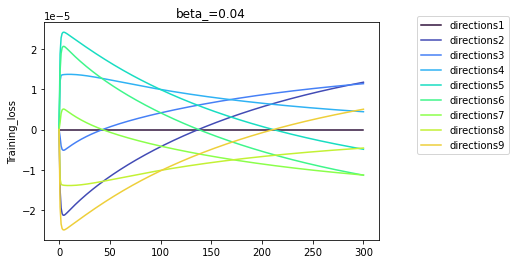

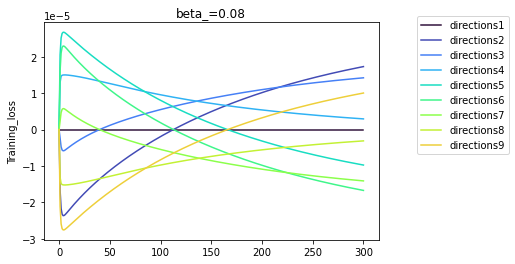

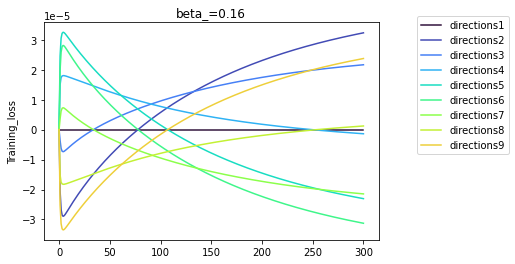

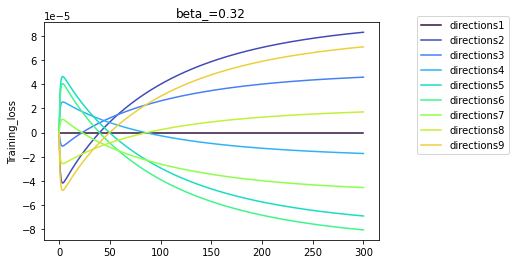

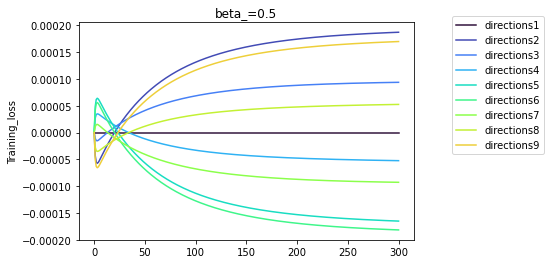

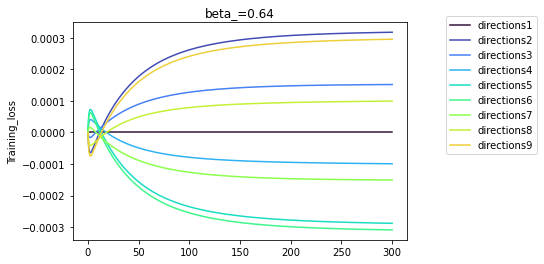

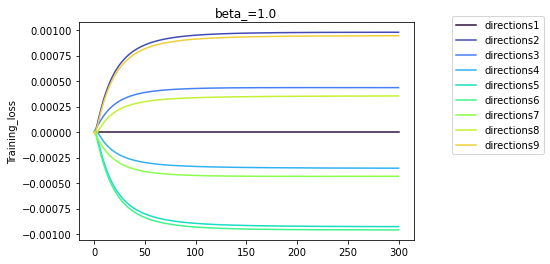

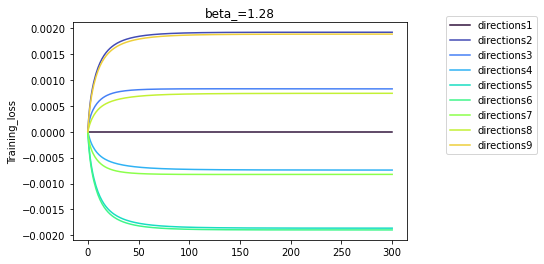

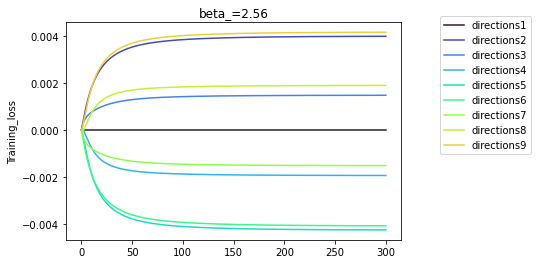

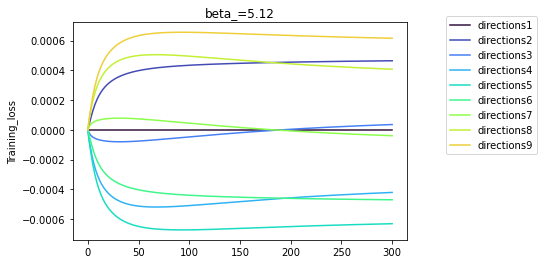

In [58]:
for j in range(len(beta)):
    plt.figure()
    for i in range(len(directions)+1):
        temp = np.array(loss_beta[j]) - test_loss_beta[j][:,i]
        plt.plot(temp,label ="directions"+str(i+1),color = cm(i*20))
        plt.ylabel("Training_loss")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.title("beta_="+str(np.around(beta[j].item(),3)))
        plt.savefig("sin_train_loss_1_loss_beta_"+str(j)+".png",bbox_inches='tight')